<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Error Analaysis Part 1: Misclassifications Extraction</h1> 
<h2 style="text-align: center;" markdown="3">Indonesia Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
[All Predictions and Reduction to Top Models](#all-preds)  
[False Positives and False Negatives](#fpfn)   
[Inter-Model Agreement](#ima) 
[Errors](#errors)
[Summary](#summary)

# Misclassification Extraction Introduction <a class="anchor" id="introduction"></a>

As we've seen throughout this project, no machine learning model is perfect. Different models excel in different areas but all make errors on some samples, especially when imbalanced calsses are involved. In these notebooks, our imbalanced classes come from household survey data taken in Indonesia in 2012. We have used this data to train models that attempt to identify poor housholds. In classificaiton terminology then, it is convention that we say 

* **Poor households are the _positive_ class**
* **Non-poor households are the _negative_ class**

As we begin to analyze misclassifications of the many models we have trained, it is important to keep the above fact in mind if the analysis is to be properly understood. There are _two_ types of error that the models can make: _false positive_ and _false negative_. Using the positive/negative class definitions above, the terminology for possible errors is

* **False Positive (FP): predicted poor, labeled non-poor**
* **False Negative (FN): predicted non-poor, labeled poor**

where the orginal classification (the "ground truth") is the _label_.

In this and the next notebook, misclassifications from every household in the 2012 Indonesia test data are considered. **A household is said to _have a model in error_ if at least one of the top 20 performing models made either a false positive or false negative prediction for that household.** The classes are labeled (the ground truth assigned) by each household's expenditures relative to a fixed poverty line.

In this notebook we will use the predictions and metrics of the saved models to construct DataFrames convenient for error analysis. To reduce the computational load in this and the next notebook, we'll first rank the models saved so far according to the mean rank metric used throughout the project, after which **we'll reduce the number of models considered**.

First, we load our standard libraries as usual:

In [1]:
%matplotlib inline

import os
import sys
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set(style="white", context="paper")
plt.rc("axes.spines", top=False, right=False, left=False, bottom=False)

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from visualization import visualize
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from data.sampler import Sampler
from features.process_features import get_vif, standardize
from features.process_features import MWI_BASIC_FEATURES

COUNTRY = 'idn'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)
    
ERRORS_DIR = Path('..', 'data', 'processed', 'idn', 'errors')
ERRORS_DIR.mkdir(exist_ok=True)

Using TensorFlow backend.


Load the test data

In [2]:
X_test, y_test, w_test = load_data(TEST_PATH, ravel=False)

# All Predictions and Reduction to Top Models <a class="anchor" id="all-preds"></a>

As the basis for our analysis, we'll construct a DataFrame with all test predictions for the top N models (N set below). The index of this DataFrame will be the unique household identifier, `hid`. The columns will consist of model predictions (probabilities that a household is "poor").

First, load every model in the model directory:

In [3]:
files = os.listdir(os.path.join(evaluation.MODELS_DIR, COUNTRY))
models = [f[:-4] for f in files if f[-4:] == '.pkl']

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,mean_rank
deepfm_full_cv,0.932415,0.525986,0.65625,0.583942,0.161349,0.943099,0.547647,8.71429
lr_full,0.910251,0.456232,0.661838,0.540131,0.212947,0.923198,0.483497,13.7143
mlp_full_undersample_cv,0.857694,0.854518,0.44028,0.581136,0.308514,0.932805,0.481756,14.4286
ensemble_simple,0.845008,0.873189,0.418192,0.565535,0.34436,0.93394,0.464792,16
lr_full_oversample,0.854459,0.843033,0.433238,0.572346,0.344135,0.926334,0.473514,16.4286
xgb_full_undersample_cv,0.835837,0.87632,0.403156,0.552247,0.366854,0.928831,0.453724,17.8571
lr_full_oversample_cv,0.851611,0.838116,0.427456,0.566159,0.348544,0.925356,0.471316,18.4286
ensemble_stacked,0.827208,0.886484,0.390749,0.542411,0.352263,0.929823,0.44074,19.5714
lr_full_undersample,0.830133,0.883593,0.394889,0.545836,0.392892,0.926233,0.44493,20.5714
lda_full,0.905845,0.405497,0.647748,0.498763,0.231353,0.911848,0.456538,20.6429


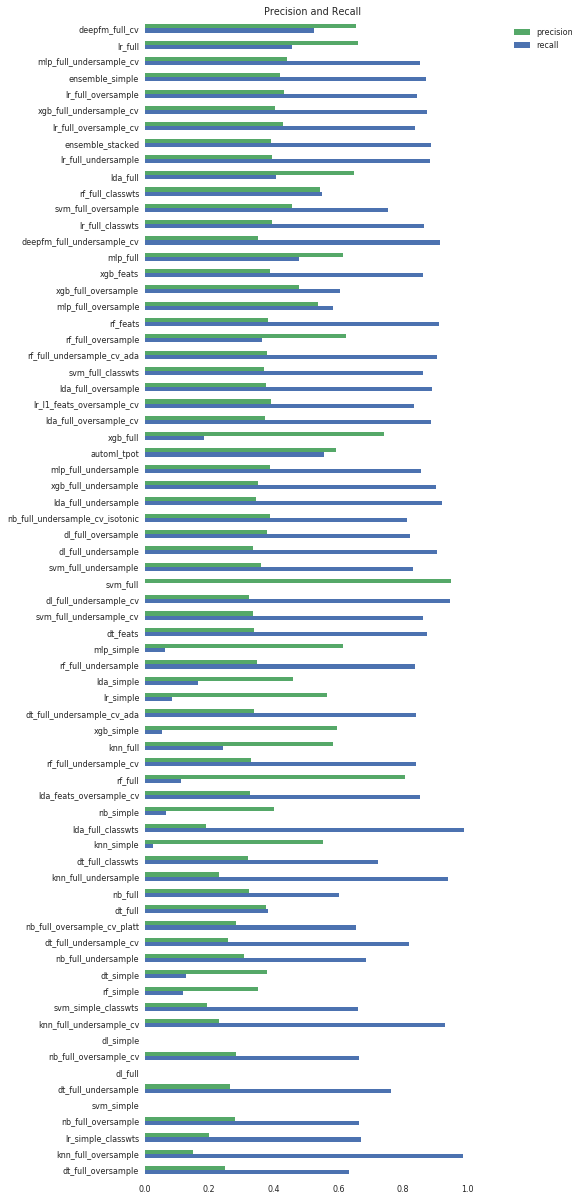

In [4]:
metrics = [evaluation.load_model_metrics(f, COUNTRY) for f in models]
results = visualize.display_model_comparison(metrics, 
                                             show_roc=False, 
                                             show_cm=False, 
                                             show_pov_rate_error=False, 
                                             highlight_best=True, 
                                             transpose=True, 
                                             rank_order=True)
visualize.display_precision_recall(results)

## Reduce to top N models for comparison

The models are rank-ordered, so we can take the top N indices to reduce to comparison.

In [5]:
TOP_N = 20
top_models = results.iloc[:TOP_N].index.values
top_models

array(['deepfm_full_cv', 'lr_full', 'mlp_full_undersample_cv',
       'ensemble_simple', 'lr_full_oversample', 'xgb_full_undersample_cv',
       'lr_full_oversample_cv', 'ensemble_stacked', 'lr_full_undersample',
       'lda_full', 'rf_full_classwts', 'svm_full_oversample',
       'lr_full_classwts', 'deepfm_full_undersample_cv', 'mlp_full',
       'xgb_feats', 'xgb_full_oversample', 'mlp_full_oversample',
       'rf_feats', 'rf_full_oversample'], dtype=object)

Now load the top N pickled models and extract their saved predictions

In [6]:
models = [evaluation.load_model(f, COUNTRY) for f in top_models]

In [7]:
model_names = [model['name'] for model in models]

In [8]:
print(f"number of predictions:\t{y_test.shape[0]}")
print(f"number of models:\t{len(model_names)}")

number of predictions:	17711
number of models:	20


## Gather all predictions

In [9]:
# to hold all predicted labels
all_preds = np.zeros((len(model_names), models[0]['y_pred'].shape[0]))

# to hold all predicted class probabilities
all_probs = np.zeros_like(all_preds)

all_preds.shape

(20, 17711)

Now we'll add the predictions and probabilities from each model to their respective dataframes.

In [10]:
for i, model in enumerate(models):
    all_preds[i, :] = model['y_pred'].ravel()
    all_probs[i, :] = model['y_prob'].ravel()
    
all_preds_df = pd.DataFrame(all_preds.T, index=y_test.index, columns=top_models).astype(bool)
all_preds_df['y_test'] = y_test.astype(bool)

all_preds_df.head()

,deepfm_full_cv,lr_full,mlp_full_undersample_cv,ensemble_simple,lr_full_oversample,xgb_full_undersample_cv,lr_full_oversample_cv,ensemble_stacked,lr_full_undersample,lda_full,...,svm_full_oversample,lr_full_classwts,deepfm_full_undersample_cv,mlp_full,xgb_feats,xgb_full_oversample,mlp_full_oversample,rf_feats,rf_full_oversample,y_test
hid,,,,,,,,,,,,,,,,,,,,,
3521040202950202,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
6310020200930608,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7310010200370305,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3372030150640309,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1213160203750307,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [11]:
all_probs_df = pd.DataFrame(all_probs.T, index=y_test.index, columns=top_models).astype(float)
all_probs_df['y_test'] = y_test.astype(bool)

all_probs_df.head(5)

,deepfm_full_cv,lr_full,mlp_full_undersample_cv,ensemble_simple,lr_full_oversample,xgb_full_undersample_cv,lr_full_oversample_cv,ensemble_stacked,lr_full_undersample,lda_full,...,svm_full_oversample,lr_full_classwts,deepfm_full_undersample_cv,mlp_full,xgb_feats,xgb_full_oversample,mlp_full_oversample,rf_feats,rf_full_oversample,y_test
hid,,,,,,,,,,,,,,,,,,,,,
3521040202950202,2.082674e-02,4.207591e-02,0.135724,0.206371,2.259811e-01,0.229414,1.982971e-01,0.309307,0.169370,0.035882,...,4.183338e-01,1.467828e-01,0.261851,4.221117e-08,0.081625,0.235575,5.472244e-13,0.488931,0.239348,False
6310020200930608,3.450578e-11,5.567545e-07,0.000031,0.000452,3.766187e-08,0.000522,2.247215e-08,0.002758,0.000004,0.002035,...,6.374005e-06,9.262122e-07,0.000024,8.867334e-27,0.000539,0.020803,1.914712e-26,0.270571,0.067704,False
7310010200370305,1.268674e-04,1.693650e-06,0.000011,0.000088,2.728485e-06,0.000088,2.372742e-06,0.002758,0.000064,0.000302,...,8.352616e-07,1.038306e-05,0.000005,3.056492e-19,0.000027,0.010758,2.355299e-21,0.184938,0.022421,False
3372030150640309,3.062290e-04,9.874715e-03,0.005942,0.030911,2.690712e-02,0.010038,2.329749e-02,0.005730,0.017010,0.006515,...,4.349396e-04,4.482004e-02,0.020463,8.997831e-11,0.006550,0.038623,1.056459e-12,0.278329,0.044228,False
1213160203750307,3.484874e-04,3.573935e-04,0.001254,0.002307,1.828366e-04,0.008949,1.120742e-04,0.002758,0.000601,0.001382,...,1.087404e-05,1.985433e-03,0.008058,1.309956e-10,0.006238,0.019935,3.657318e-11,0.295227,0.089020,False


We'll write these files to our data directory so that we can look at the results in later notebooks as well.

In [12]:
all_preds_df.to_csv(Path(ERRORS_DIR, f'all_preds_top_{TOP_N}_models.csv'), index='hid')
all_probs_df.to_csv(Path(ERRORS_DIR, f'all_probs_top_{TOP_N}_models.csv'), index='hid')

# False Positives and False Negatives <a class="anchor" id="fpfn"></a>

## Map into FN and FP

Now we will map the DataFrames entries into false positive and false negative values. In other words, the false negative DataFrame entry for household $i$ and model $j$ will be $True$ if that prediction was a false negative (predicted non-poor, labeled poor), otherwise it will be false.

**NOTE: A `False` entry for e.g. the FN (predicted non-poor, labeled poor) DataFrame does _not_ neccesarily mean that the prediction was then a `True` FP (prediced poor, labeled non-poor). It could have been just as well been predicted poor, labeled poor (true positive TP).**

In [13]:
fn = all_preds_df.apply(lambda x: ~x & all_preds_df.y_test)
fn.head()

,deepfm_full_cv,lr_full,mlp_full_undersample_cv,ensemble_simple,lr_full_oversample,xgb_full_undersample_cv,lr_full_oversample_cv,ensemble_stacked,lr_full_undersample,lda_full,...,svm_full_oversample,lr_full_classwts,deepfm_full_undersample_cv,mlp_full,xgb_feats,xgb_full_oversample,mlp_full_oversample,rf_feats,rf_full_oversample,y_test
hid,,,,,,,,,,,,,,,,,,,,,
3521040202950202,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6310020200930608,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7310010200370305,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3372030150640309,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1213160203750307,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
fp = all_preds_df.apply(lambda x: x & ~all_preds_df.y_test)
fp.head()

,deepfm_full_cv,lr_full,mlp_full_undersample_cv,ensemble_simple,lr_full_oversample,xgb_full_undersample_cv,lr_full_oversample_cv,ensemble_stacked,lr_full_undersample,lda_full,...,svm_full_oversample,lr_full_classwts,deepfm_full_undersample_cv,mlp_full,xgb_feats,xgb_full_oversample,mlp_full_oversample,rf_feats,rf_full_oversample,y_test
hid,,,,,,,,,,,,,,,,,,,,,
3521040202950202,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
6310020200930608,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7310010200370305,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3372030150640309,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1213160203750307,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## FP and FN Plots

Now that we have an understanding of which models classified which households incorrectly, we can begin to examine these misclassifications. Understanding patterns in missclassifications can help uncover towards improvements to the modeling, data collection or data quality issues, and bugs that ended up in the software.

First, we'll look at whether or not there were more false positives or false negatives. Then, we'll look at how many of the models "agreed" on the wrong answer. We'll start this by plotting the number of households against the percentage of models that agreed on the incorrect label.

[None, None]

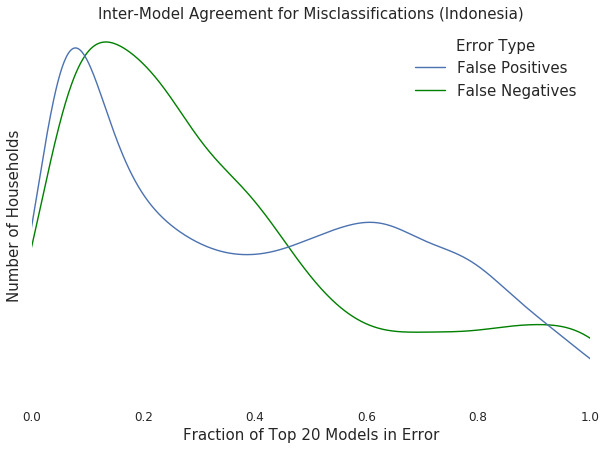

In [15]:
ax = fn.drop('y_test', axis=1).mean(axis=1).pipe(lambda x: x[x > 0]).plot.density(xlim=(0, 1), 
                                                                                  label="False Negatives",
                                                                                  figsize=(10, 7), 
                                                                                  fontsize=12, c='g')

fp.drop('y_test', axis=1).mean(axis=1).pipe(lambda x: x[x > 0]).plot.density(xlim=(0, 1), ax=ax, label="False Positives", fontsize=12)

ax.set_yticklabels('')
ax.set_title("Inter-Model Agreement for Misclassifications (Indonesia)", size=15)
ax.set_xlabel(f"Fraction of Top {fn.shape[1] - 1} Models in Error", size=15)
ax.set_ylabel("Number of Households", size=15)
handles, labels = ax.get_legend_handles_labels()
plt.setp(ax.legend(handles[::-1], labels[::-1], title="Error Type", fontsize=15, bbox_to_anchor=(1, 1)).get_title(), fontsize=15)

In general, more households are consistently falsely predicted to be poor accross all models than falsely predicted to be not poor (false positive densitiy shifted to the right). What this means is that it should be easier for ensemble methods to correct for false negatives than false positives, since heterogeneity (the primary advantage of ensembling) is less useful when all models are making the same error.

We'll save the false positive and false negative dataframes so we can use them in future notebooks.

In [16]:
fp.to_csv(Path(ERRORS_DIR, f'fp_top_{TOP_N}_models.csv'), index='hid')
fn.to_csv(Path(ERRORS_DIR, f'fn_top_{TOP_N}_models.csv'), index='hid')

# Errors <a class="anchor" id="errors"></a>

In addition to looking at the false positives and false negatives separately, we can also look at them together. We'll construct a single dataframe that just indicates whether or not a model was incorrect in its prediction of a particular household.

In [17]:
errors = all_preds_df.apply(lambda x: x != all_preds_df.y_test)
errors.head()

,deepfm_full_cv,lr_full,mlp_full_undersample_cv,ensemble_simple,lr_full_oversample,xgb_full_undersample_cv,lr_full_oversample_cv,ensemble_stacked,lr_full_undersample,lda_full,...,svm_full_oversample,lr_full_classwts,deepfm_full_undersample_cv,mlp_full,xgb_feats,xgb_full_oversample,mlp_full_oversample,rf_feats,rf_full_oversample,y_test
hid,,,,,,,,,,,,,,,,,,,,,
3521040202950202,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
6310020200930608,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7310010200370305,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3372030150640309,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1213160203750307,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


We'll also save this dataframe for future use.

In [18]:
errors.to_csv(Path(ERRORS_DIR, f'errors_top_{TOP_N}_models.csv'), index='hid')

No we can plot the distribution of ageement among the the models from `0.0`, where no models got that household wrong, to `1.0`, where all of the models got a household wrong.

What we see initially is that the vast majority of households are never misclassified by even a single model.

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


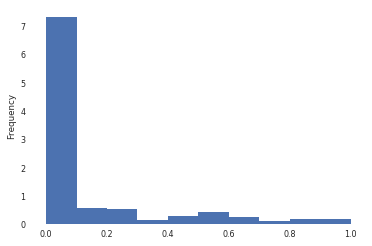

In [19]:
error_agreement = errors.drop('y_test', axis=1).mean(axis=1)
error_agreement.sort_values(ascending=False).plot.hist(normed=True)

In [20]:
# false: never misclass
# true: ever misclass
(error_agreement > 0).value_counts(normalize=True)

False    0.677489
True     0.322511
dtype: float64

There are about 70% of households that are never missclassified, and all of the models are in total agreement. With these included in our plot, it can be difficult to see the patterns in households that were missclassified. We can re-create the histogram above, but leave out the households that every model got right:

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


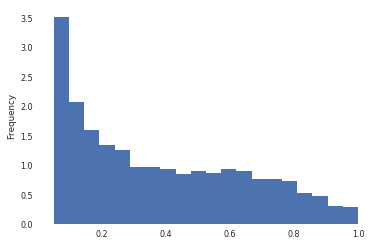

In [21]:
error_agreement[(error_agreement > 0)].plot.hist(bins=20, normed=True)

# Summary <a class="anchor" id="summary"></a>

We already saw that almost 70% of households not a single model gets wrong. These are the easy cases to predict.

In this new histogram, we can see an interesting shape where there is a group of households that around 70% of the models get wrong. In the next notebook we'll look at some properties of the households that were misclassified.